In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ECE_Project')

In [0]:
import CNN_Lib
import CNN_BuildingBlock_Lib as BB
import RNN_BuildingBlock_Lib as RNN_BB
import CombinationModel as ComboCNN
import CombinationModel_RNN_CNN as RNN_CNN
import CombinationModel_LSTM_FCN as LSTM_FCN
import numpy as np 
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import random
import pdb
import copy
import matplotlib.pyplot as plt


In [4]:
dir = '/content/gdrive/My Drive/Colab Notebooks/ECE_Project'
X_test = np.load(dir + '/X_test.npy')
y_test = np.load(dir + '/y_test.npy')
person_train_valid = np.load(dir + '/person_train_valid.npy')
X_train_valid = np.load(dir + '/X_train_valid.npy')
y_train_valid = np.load(dir + '/y_train_valid.npy')
person_test = np.load(dir + '/person_test.npy')
print ('Training/Valid data shape: {}' .format(X_train_valid.shape))
print ('Test data shape: {}' .format(X_test.shape))
print ('Training/Valid target shape: {}' .format(y_train_valid.shape))
print ('Test target shape: {}' .format(y_test.shape))
print ('Person train/valid shape: {}' .format(person_train_valid.shape))
print ('Person test shape: {}' .format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
#transform data into torch-readable data types
#2115 number of trials from 9 people
#four possible classes of outputs
Xtrain = torch.from_numpy(X_train_valid)
Ytrain = torch.from_numpy(y_train_valid)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(y_test)

In [0]:
def map_to_class(input_labels):
  mask1 = (input_labels == 769)*0
  mask2 = (input_labels == 770)*1
  mask3 = (input_labels == 771)*2
  mask4 = (input_labels == 772)*3
  return (mask1 + mask2 + mask3 + mask4)

In [0]:
#perhaps normalizing noisy data will help learning?
#tried first with L2, improved slightly...
def normalize(x):
  return F.normalize(x, p=1, dim=2)


In [0]:
def plot_val_train(validation_acc, train_acc, k, its):
  f = plt.figure(figsize=(15, 10))
  plt.title(f"Model Performance while Validating on K-Fold {k}")
  plt.plot(validation_acc, 'g-')
  plt.plot(train_acc, 'b-')
  plt.xticks(np.arange(0, its, step=50))  # Set label locations.
  return f


In [0]:
def smooth(x,window_size=11,window='hanning'):
  """
    Adapted from SciPy Cookbook
    Window can be: ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
  """
  smoothed = np.r_[x[window_size-1:0:-1], x, x[-2:-window_size-1:-1]]
  
  #moving average
  if window == 'flat':
      w = np.ones(window_len,'d')
  else:
      w = eval('np.' + window + '(window_size)')

  smoothed = np.convolve(w/w.sum(), smoothed, mode='valid')
  if len(x) < len(smoothed):
    dif = abs(len(x) - len(smoothed))//2
    smoothed = smoothed[dif:len(smoothed)-dif]
  return smoothed

In [0]:
def augment_data(data_set, window_size, window):
  out = np.zeros_like(data_set)
  out = torch.from_numpy(out)
  for i in range(data_set.shape[0]):
    for j in range(data_set.shape[1]):
      out[i,j,:] = torch.from_numpy(smooth(data_set[i,j,:], window_size, window))
  return out

Augmenting the Dataset does Wonders! Without it, we could not exceed 40% validation reliably. Now, we can get up to 80%!

In [11]:
######### AUGMENT DATASET
Augmented = augment_data(X_train_valid, 11,'hanning')
Augmented.size()
OutX = torch.cat((Xtrain, Augmented),0)
OutY = torch.cat((Ytrain, Ytrain),0)
print(OutX.size())

Xtrain = OutX
Ytrain = OutY

torch.Size([4230, 22, 1000])


In [12]:
########## INITIALIZE LSTM-FCN COMBINATION MODEL ########## 

Trials = Xtrain.size(0) 
_, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape


#-----RNN tweak here----#
hidden_dim = 64 #above 150 and we get low training accuracy
num_layers = 5 #5 seems to do better with 64
nonlinearity = 'tanh'
initialization = 'xavierUniform'


#-----CNN tweak here----#
num_filters = [128, 100, 64] #64 on the last layer lets val climb up to 48
batch_size = 350   #smaller batch sizes (less than 50) offer a regularization effect BUT 350 gives training up to 50 finally
num_classes = 4
L2 = 0.5 #model doesn't seem to be expressive enough if L2 is larger than .1
cnnfilter_stride = [2, 1, 1] #big filter stride makes training to acceptable validation take longer. 
cnnfilter_size = [8, 3, 3] #smaller filter size appears to make higher validation from the beginning. lower than 2 is pretty bad?
cnn_padding = ['same', 'same', 'same']
use_bias = [False, True, False]
use_maxpool = [False, False, False] #not using it makes the model overfit
pool_size = [5, 3, 801] #801 ->lout 200 | #501 --> 500 | 351 --> 650
pool_stride = [2, 1, 1]
avg_pool_size = 1
avg_pool_stride = 1
use_batchnorm = [True, True, True]
eps = [1e-3, 1e-3, 1e-3]
momentum = [0.99, 0.99, 0.99]
affine = [False, False, False]
dropout = [0.3, 0.3, 0.3, 0.8]

#----NORM DATA tweak here---#
norm = False

#-----OPTIM tweak here----#
learning_rate = 0.0001 #when set to 0.2, the validation was very noisy | 0.001 and less noisy, but data SUPER overfits

combo_model = LSTM_FCN.CombinationModel_LSTM_FCN(InputDim, SeqDim, hidden_dim, num_layers, num_filters, 
                                                 cnnfilter_size, cnnfilter_stride, cnn_padding, 
                                                 use_bias, num_classes, use_maxpool, pool_size, pool_stride, 
                                                 avg_pool_size, avg_pool_stride, use_batchnorm, 
                                                 eps, momentum, affine, dropout)
combo_model.to('cuda:0') #--- activate the GPU


CombinationModel_LSTM_FCN(
  (LSTM1): LSTM(22, 64, num_layers=5, bidirectional=True)
  (DropOutFC): Dropout(p=0.8, inplace=False)
  (CNN_Block1): EEG_CNN_BuildingBlock2(
    (CNN): Conv1d(22, 128, kernel_size=(8,), stride=(2,), padding=(503,), bias=False)
    (BatchNorm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=False, track_running_stats=True)
    (RELU): ReLU()
    (DropOut): Dropout(p=0.3, inplace=False)
  )
  (CNN_Block2): EEG_CNN_BuildingBlock2(
    (CNN): Conv1d(128, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (BatchNorm): BatchNorm1d(100, eps=0.001, momentum=0.99, affine=False, track_running_stats=True)
    (RELU): ReLU()
    (DropOut): Dropout(p=0.3, inplace=False)
  )
  (CNN_Block3): EEG_CNN_BuildingBlock2(
    (CNN): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (BatchNorm): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=False, track_running_stats=True)
    (RELU): ReLU()
    (DropOut): Dropout(p=0.3, inplace=False)
  )
  (A

In [0]:
########## CHOOSE LOSS  ###########
loss = torch.nn.CrossEntropyLoss()

######### CHOOSE OPTIMIZER ########
optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2)
#optim = torch.optim.Adadelta(combo_model.parameters()) << does worse than Adam, we overfit so much 

...... Training for Epoch 0 ......
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


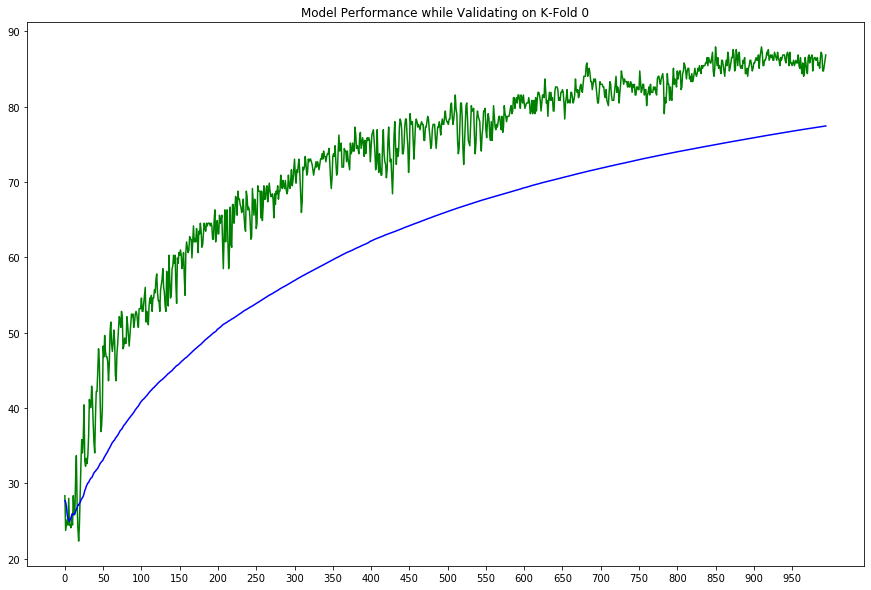

______ Training for k-folds [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


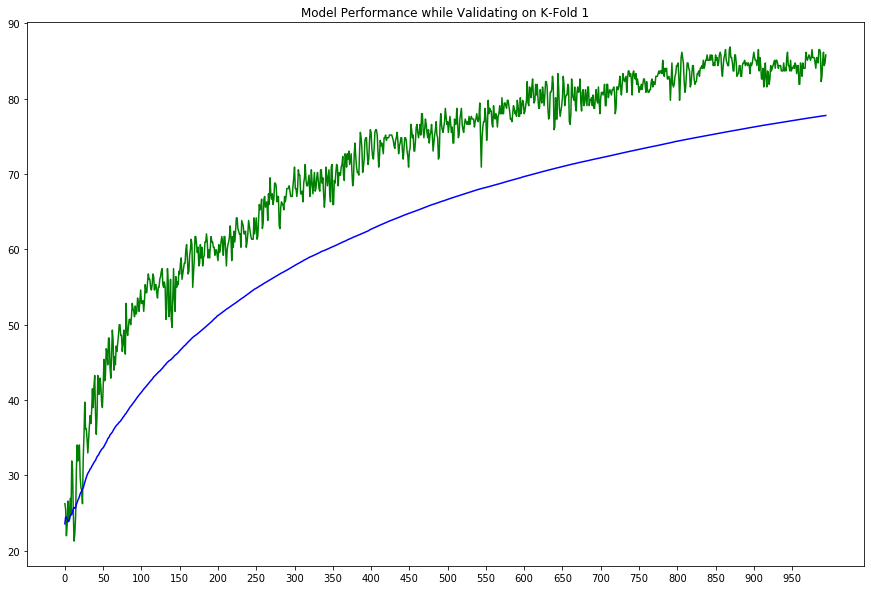

______ Training for k-folds [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14] ______


KeyboardInterrupt: ignored

In [15]:
######## TRAIN IT ######## .... got up to 58% but huge range. from 30 was the low.
#------ With Early Stopping AND K-Fold Validation -----#
epochs = 1
kfolds = 15
iterations = 1000 #seems to need WAY more iterations
iter_ = 0
validate_fold = 0
SEED = 2000

stop_now = False
loss_store = [[] for i in range(kfolds)]
validation_store = [[] for i in range(kfolds)]
training_store = [[] for i in range(kfolds)]
network_store = [[] for i in range(kfolds)]
model_store = []

#normalize here
if norm:
  Xtrain = normalize(Xtrain)

#k fold validation here
np.random.seed(random.randint(1,SEED))
fold_size = int(Trials/kfolds)
idx = np.arange(Trials)
np.random.shuffle(idx)
Xtrain_Shuffled = Xtrain[idx]
Ytrain_Shuffled = Ytrain[idx]

FoldsX = Xtrain_Shuffled.split(fold_size)
FoldsY = Ytrain_Shuffled.split(fold_size)

for epoch in range(epochs):
  if stop_now:
    break

  print(f"...... Training for Epoch {epoch} ......")
  for k in range(kfolds): 
    train_correct = 0
    train_total = 0


    #create training folds by excluding validate fold
    train_folds = list(range(kfolds))
    del train_folds[validate_fold]
    train_folds = np.array(train_folds)
    TrainX = torch.cat([FoldsX[f] for f in train_folds]) 
    TrainY = torch.cat([FoldsY[f] for f in train_folds])

    #create validate fold
    ValidateX = FoldsX[validate_fold]
    ValidateY = FoldsY[validate_fold]

    #initialize the network within the kfold loop
    combo_model = LSTM_FCN.CombinationModel_LSTM_FCN(InputDim, SeqDim, hidden_dim, num_layers, num_filters, 
                                                 cnnfilter_size, cnnfilter_stride, cnn_padding, 
                                                 use_bias, num_classes, use_maxpool, pool_size, pool_stride, 
                                                 avg_pool_size, avg_pool_stride, use_batchnorm, 
                                                 eps, momentum, affine, dropout)

    combo_model.to('cuda:0') #--- activate the GPU
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2) 
    

    print(f"______ Training for k-folds {train_folds} ______")
    for i in range(iterations):
      #do the batches
      idx = np.arange(TrainX.size(0))
      np.random.shuffle(idx)
      idx = idx[0:batch_size]

      #process the input data
      xtrain = TrainX[idx].view(batch_size, SeqDim, InputDim)
      xtrain = xtrain.to('cuda:0').requires_grad_()
      ytrain = TrainY[idx]

      #put the model in training mode
      combo_model.train(True)

      #forward pass
      optim.zero_grad()
      outFC = combo_model.forward(xtrain.float())
  
      #map to classes
      classes = map_to_class(ytrain.long())
      #classes = torch.cat((classes, classes))
      classes = classes.to('cuda:0')

      #backward pass (gradient calculation)
      probs = loss(outFC, classes)
      probs.backward()

      #update weights
      optim.step()

      #update iter counter
      iter_+=1

      #calculate training accuracy
      #train_pred = F.softmax(outFC, 1)
      values, predicted = torch.max(outFC, 1)
      train_correct += (1*(predicted == classes)).sum()
      train_total += float(classes.size(0))

      if i % 200:
        #print(f"______ Validating for k-fold {k} ______")
        combo_model.eval()
        
        #process the input data
        xvalid = ValidateX.view(-1, SeqDim, InputDim)
        xvalid = xvalid.to('cuda:0')
        yvalid = ValidateY

        #forward prop
        predict = combo_model(xvalid.float())
        
        #predict
        #pred = F.softmax(predict, 1)
        values, predicted_classes = torch.max(predict, 1)
        expected_classes = map_to_class(yvalid)
        correct = (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
        total =float(predicted_classes.size(0))

        #evaluate
        validation_accuracy = 100*(correct/total)
        training_accuracy = 100*(train_correct/train_total)

        #print(f"correct: {correct}, total: {total}")
        #print(f"prediction: {predicted_classes}\nexpected_classes: {expected_classes}")
        #print(f"Iteration: {iter_}, Loss: {probs.item()}, Validation Accuracy: {validation_accuracy}%, Training Accuracy: {training_accuracy}%\n")  

        #store info for graphing later
        validation_store[k].append(validation_accuracy.item())
        loss_store[k].append(probs.item())
        training_store[k].append(training_accuracy.item())
        
        #--- Early stopping criterion here --- #
        if validation_accuracy > 89.0:
          #store
          print("Early Stopping!")
          stop_now = True
          break
    
    #iterate the validate fold
    validate_fold +=1

    #store the model
    model_store.append(copy.deepcopy(combo_model))

    #plot things
    plot = plot_val_train(validation_store[k], training_store[k], k, iterations)    
    plt.show(plot)

TypeError: ignored

In [19]:
#Find Best Model and Test It
#best_ind = np.argmax(np.max(np.array(validation_store), 1))
best_model = model_store[1]

print(f"______ Evaluating On Test Data ______")
best_model.eval()

total = 0
correct = 0

#process the input data
xtest = Xtest.view(-1, SeqDim,InputDim)
xtest = xtest.to('cuda:0')
ytest = Ytest

#forward prop
predict = best_model(xtest.float())

#predict
values, predicted_classes = torch.max(predict, 1)
expected_classes = map_to_class(ytest)        
correct += (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
total +=float(predicted_classes.size(0))

#evaluate
test_accuracy = 100*(correct/total)

print(f"correct: {correct}, total: {total}")
print(f"Testing Accuracy: {test_accuracy}%")  


______ Evaluating On Test Data ______
correct: 227, total: 443.0
Testing Accuracy: 51.24153518676758%


/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


STORING THE PARAMS THAT GAVE US ACCEPTABLY NONNOISY DATA HALLELUJAH

In [0]:
########## INITIALIZE LSTM-FCN COMBINATION MODEL ########## 

Trials, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape


#-----RNN tweak here----#
hidden_dim = 64 #above 150 and we get low training accuracy
num_layers = 5 #5 seems to do better with 64
nonlinearity = 'tanh'
initialization = 'xavierUniform'


#-----CNN tweak here----#
num_filters = [128, 100, 64] #64 on the last layer lets val climb up to 48
batch_size = 350   #smaller batch sizes (less than 50) offer a regularization effect
num_classes = 4
L2 = 0.5 #model doesn't seem to be expressive enough if L2 is larger than .1
cnnfilter_stride = [2, 1, 1] #big filter stride makes training to acceptable validation take longer. 
cnnfilter_size = [8, 3, 3] #smaller filter size appears to make higher validation from the beginning. lower than 2 is pretty bad?
cnn_padding = ['same', 'same', 'same']
use_bias = [False, True, False]
use_maxpool = [False, False, False] #not using it makes the model overfit
pool_size = [5, 3, 801] #801 ->lout 200 | #501 --> 500 | 351 --> 650
pool_stride = [2, 1, 1]
avg_pool_size = 1
avg_pool_stride = 1
use_batchnorm = [True, True, True]
eps = [1e-3, 1e-3, 1e-3]
momentum = [0.99, 0.99, 0.99]
affine = [False, False, False]
dropout = [0.1, 0.1, 0.1, 0.8]

#----NORM DATA tweak here---#
norm = False

#-----OPTIM tweak here----#
learning_rate = 0.0001 #when set to 0.2, the validation was very noisy | 0.001 and less noisy, but data SUPER overfits

combo_model = LSTM_FCN.CombinationModel_LSTM_FCN(InputDim, SeqDim, hidden_dim, num_layers, num_filters, 
                                                 cnnfilter_size, cnnfilter_stride, cnn_padding, 
                                                 use_bias, num_classes, use_maxpool, pool_size, pool_stride, 
                                                 avg_pool_size, avg_pool_stride, use_batchnorm, 
                                                 eps, momentum, affine, dropout)
combo_model.to('cuda:0') #--- activate the GPU
